In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import Dropout

import warnings
warnings.filterwarnings("ignore")

# Data processing

### Loading data

In [2]:
raw_data = pd.read_csv("data_bitcoin.csv")

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7221277 entries, 0 to 7221276
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 330.6 MB


In [4]:
# Chuyển timestamp (dạng số) thành thời gian thực (dạng ngày)
raw_data['date'] = pd.to_datetime(raw_data['Timestamp'],unit='s').dt.date
raw_data

,Timestamp,Open,High,Low,Close,Volume,date
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01
...,...,...,...,...,...,...,...
7221272,1.758758e+09,113319.00,113328.00,113319.00,113326.00,0.005044,2025-09-24
7221273,1.758758e+09,113326.00,113326.00,113317.00,113326.00,0.047516,2025-09-24
7221274,1.758758e+09,113326.00,113367.00,113326.00,113360.00,0.209290,2025-09-24
7221275,1.758758e+09,113367.00,113386.00,113354.00,113354.00,0.416070,2025-09-24


In [5]:
# Lấy trung bình theo ngày
grouped_data = raw_data.groupby('date', as_index = False).mean()
grouped_data

,date,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01,1.325437e+09,4.645697,4.645697,4.645697,4.645697,0.011919
1,2012-01-02,1.325506e+09,4.975000,4.975000,4.975000,4.975000,0.007014
2,2012-01-03,1.325592e+09,5.085500,5.085500,5.085500,5.085500,0.074365
3,2012-01-04,1.325678e+09,5.170250,5.170396,5.170250,5.170396,0.074468
4,2012-01-05,1.325765e+09,5.954292,5.954361,5.954292,5.954361,0.048839
...,...,...,...,...,...,...,...
5011,2025-09-20,1.758370e+09,115831.676389,115836.591667,115827.770833,115831.937500,0.772215
5012,2025-09-21,1.758456e+09,115617.845833,115622.842361,115613.699306,115618.345139,0.548054
5013,2025-09-22,1.758542e+09,113210.881250,113233.609028,113185.258333,113209.250000,1.355390
5014,2025-09-23,1.758629e+09,112568.515972,112586.955556,112550.328472,112567.609722,1.019471


### Train and test split

In [6]:
# 95% train, 5% test
train_size = int(len(grouped_data) * 0.95)
test_size = len(grouped_data) - train_size
df_train = grouped_data.iloc[0:train_size, :]
df_test = grouped_data.iloc[train_size:len(grouped_data), :]
print("Train size: {}, Test size: {}". format(len(df_train), len(df_test)))

Train size: 4765, Test size: 251


### Visualizing data

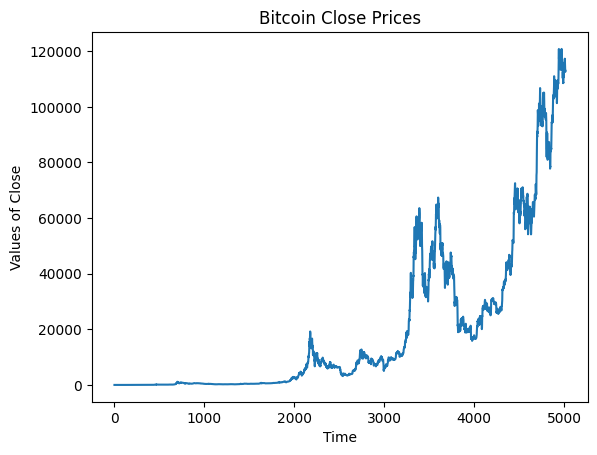

In [7]:
data_plot = grouped_data.loc[:, ["Close"]].values
plt.plot(data_plot)
plt.xlabel("Time")
plt.ylabel("Values of Close")
plt.title("Bitcoin Close Prices")
plt.show()


In [8]:
# we will predict Close values
dataset = df_train.loc[:, ["Close"]].values

#reshape
dataset = dataset.reshape(-1, 1)

### Scaling data

In [9]:
# MinMaxScaler: new_v = (v_0 - min_v) / (max_v - min_v)
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(dataset)
data_scaled

array([[3.09373140e-06],
       [6.17875735e-06],
       [7.21396090e-06],
       ...,
       [8.98106226e-01],
       [9.18715169e-01],
       [9.32302417e-01]], shape=(4765, 1))

In [11]:
# Tạo sequences data train
X_train = []
y_train = []
time_step = 10
for i in range(time_step, data_scaled.shape[0]):
    X_train.append(data_scaled[i-time_step:i, 0])
    y_train.append(data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train shape:  (4755, 10)
y_train shape:  (4755,)


In [12]:
# Reshaping X_train to 3D  (samples, time_steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)

X_train shape:  (4755, 10, 1)
y_train shape:  (4755,)


# Recurrent Neural Network (RNN)

In [13]:
# RNN 4 hidden layers
regressor = Sequential()
function = "relu"

# Layer 1
regressor.add(SimpleRNN(units = 50, activation=function, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Layer 2
regressor.add(SimpleRNN(units = 50, activation=function, return_sequences = True))
regressor.add(Dropout(0.2))

# Layer 3
regressor.add(SimpleRNN(units = 50, activation=function, return_sequences = True))
regressor.add(Dropout(0.2))

# Layer 4
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# Output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
# epoch= 100

Epoch 1/100


2025-09-29 18:44:00.446020: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0113
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0027
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016
Epoch 6/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014
Epoch 7/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014
Epoch 8/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015
Epoch 9/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012
Epoch 10/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012
Epoch 11/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010
Epoch 12/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011
Epoch 13/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010
Epoch 14/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5851e-04
Epoch 15/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/st

# predict and visualising RNN model

In [14]:
real_bitcoin_price = df_test.loc[:, ["Close"]].values
real_bitcoin_price.shape

(251, 1)

In [15]:
# Để dự đoán điểm đầu tiên trong test set cần timestep điểm ngay trước nó (Nằm trong train set)
df_total = pd.concat((df_train['Close'], df_test['Close']), axis = 0)
inputs = df_total[len(df_total) - len(df_test) - time_step:].values.reshape(-1,1)
inputs = scaler.transform(inputs)  # min max scaler

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


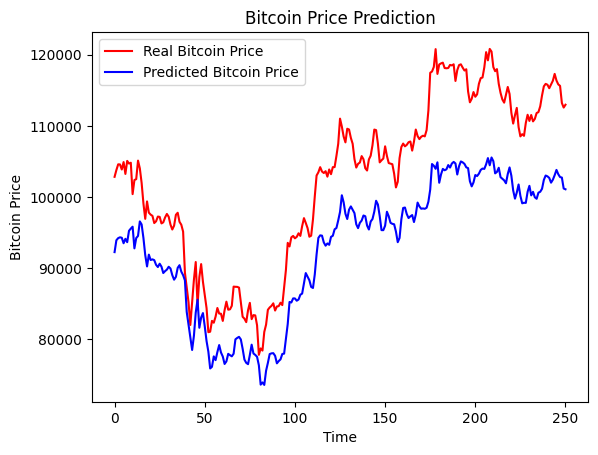

In [16]:
# Tạo sequence data test
X_test = []
for i in range(time_step, inputs.shape[0]):
    X_test.append(inputs[i-time_step:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_bitcoin_price = regressor.predict(X_test)
predicted_bitcoin_price = scaler.inverse_transform(predicted_bitcoin_price)

# Visualising
plt.plot(real_bitcoin_price, color = 'red', label = 'Real Bitcoin Price')
plt.plot(predicted_bitcoin_price, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

# LSTM

### Train and test split

In [17]:
train_size = int(len(grouped_data) * 0.90)
test_size = len(grouped_data) - train_size
df_train = grouped_data.iloc[0:train_size, :]
df_test = grouped_data.iloc[train_size:len(grouped_data), :]
print("DF_Train size: {}, DF_Test size: {}". format(len(df_train), len(df_test)))

DF_Train size: 4514, DF_Test size: 502


In [18]:
dataset = df_train.loc[:, ["Close"]].values
dataset.shape

(4514, 1)

In [19]:
#reshape
dataset = dataset.reshape(-1, 1)
dataset.shape

(4514, 1)

### Scaling data

In [20]:
scaler = MinMaxScaler(feature_range = (0, 1))
data_scaled = scaler.fit_transform(dataset)

In [21]:
# We divide the DATA_SCALED by Training %50, Test %50
train_size = int(len(data_scaled) * 0.50)
test_size = len(data_scaled) - train_size
data_scaled_train = data_scaled[0:train_size, :]
data_scaled_test = data_scaled[train_size:len(data_scaled), :]

print("data_scaled_train size: {}\ndata_scaled_test size: {}". format(len(data_scaled_train), len(data_scaled_test)))
print("data_scaled_train shape: {}\ndata_scaled_test shape: {}". format(data_scaled_train.shape, data_scaled_test.shape))

data_scaled_train size: 2257
data_scaled_test size: 2257
data_scaled_train shape: (2257, 1)
data_scaled_test shape: (2257, 1)


In [22]:
# Tạo sequences data (train dataset)
time_step = 10
dataX = []
dataY = []
for i in range(len(data_scaled_train) - time_step - 1):
    a = data_scaled_train[i:(i + time_step), 0]
    dataX.append(a)
    dataY.append(data_scaled_train[i + time_step, 0])
trainX = np.array(dataX)
trainY = np.array(dataY)

print("trainX shape: {}\ntrainY shape: {}". format(trainX.shape, trainY.shape))

trainX shape: (2246, 10)
trainY shape: (2246,)


In [23]:
# Tạo sequences data (test dataset)
dataX = []
dataY = []
for i in range(len(data_scaled_test) - time_step -1):
    a = data_scaled_test[i:(i + time_step), 0]
    dataX.append(a)
    dataY.append(data_scaled_test[i + time_step, 0])
testX = np.array(dataX)
testY = np.array(dataY)

print("testX shape: {}\ntestY shape: {}". format(testX.shape, testY.shape))

testX shape: (2246, 10)
testY shape: (2246,)


In [24]:
# Reshaping to 3D
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print("X_train shape: ",trainX.shape)
print("X_test shape: ",testX.shape)

X_train shape:  (2246, 1, 10)
X_test shape:  (2246, 1, 10)


### Model

In [25]:
# model
model = Sequential()
model.add(LSTM(256, input_shape = (1, time_step))) # 256 LSTM neuron(block)
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss= "mean_squared_error", optimizer = "adam")
model.fit(trainX, trainY, epochs=100, batch_size=50)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8798e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1600e-05
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9164e-05
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8620e-05
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1204e-05
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5583e-05
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5840e-05
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5049e-05
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1481e-05
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2147e-05
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9837e-05
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0376e-05
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7030e-05
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6453e-05
Epoch 15/100
45

In [26]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       273,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 820,997 (3.13 MB)

 Trainable params: 273,665 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 547,332 (2.09 MB)

### prediction and visualization

In [27]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_ = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_ = scaler.inverse_transform([testY])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(trainY_[0], trainPredict[:, 0]))
print("Train Score: %.2f RMSE" % (train_score))
test_score = math.sqrt(mean_squared_error(testY_[0], testPredict[:, 0]))
print("Test Score: %.2f RMSE" % (test_score))

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Train Score: 188.53 RMSE
Test Score: 3276.91 RMSE


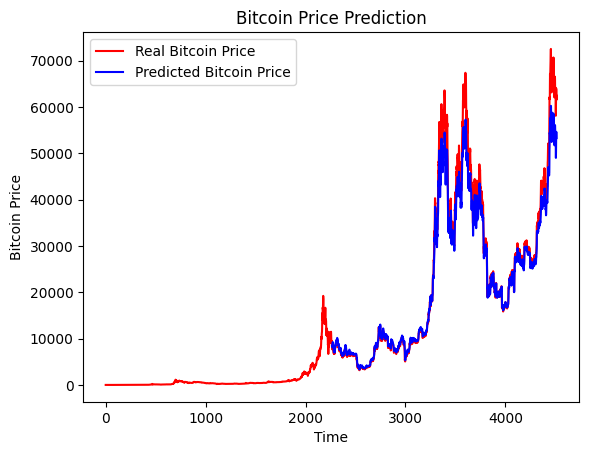

In [29]:
# Visualising
# shifting train
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(trainPredict) + time_step, :] = trainPredict
# shifting test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (time_step * 2) + 1:len(data_scaled) - 1, :] = testPredict
plt.plot(scaler.inverse_transform(data_scaled), color = 'red', label = 'Real Bitcoin Price')
plt.plot(testPredictPlot, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()